# Customer Segmentation & Recommendation System

**Goal:** Analyze real e-commerce transactions to segment customers and generate product recommendations to support marketing and sales decisions.

**Key steps:**
- Data cleaning & preprocessing
- Exploratory analysis (sales trends, top products, customer behavior)
- Customer segmentation (K-Means)
- Recommendation logic (association rules / product affinity)

**Outputs:**
- Customer segments with insights
- Segment-level spending analysis
- Recommendation examples and business suggestions


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# If needed (install once in terminal/cmd, not inside notebook):
# pip install mlxtend
from mlxtend.frequent_patterns import apriori, association_rules

from itertools import combinations
from collections import Counter


## 1. Data Loading


In this step, the raw transaction dataset is loaded and an initial overview is performed to understand the structure and size of the data.


In [2]:
df = pd.read_excel("Online_Retail.xlsx", sheet_name=0)
df.head()


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
df.shape


(525461, 8)

The dataset contains 525,461 transaction records and 8 variables. 
This indicates a medium-to-large scale retail dataset suitable for customer behavior analysis.


In [4]:
df.columns


Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

## 2. Data Cleaning & Preprocessing

- Remove rows with missing customer IDs
- Filter invalid transactions (e.g., non-positive quantities)
- Standardize product descriptions


In [5]:
df = df.dropna(subset=["Customer ID"])
df = df[df["Quantity"] > 0]

df["Description"] = df["Description"].astype(str).str.strip()
df["Invoice"] = df["Invoice"].astype(str)

df.shape


(407695, 8)

In [6]:
df.groupby("Invoice")["StockCode"].nunique().sort_values(ascending=False).head()


Invoice
507235    250
500356    250
526089    240
525928    221
511051    220
Name: StockCode, dtype: int64

## 3. Exploratory Data Analysis (EDA)

We review top-selling products and the distribution of basket sizes (number of unique products per invoice).


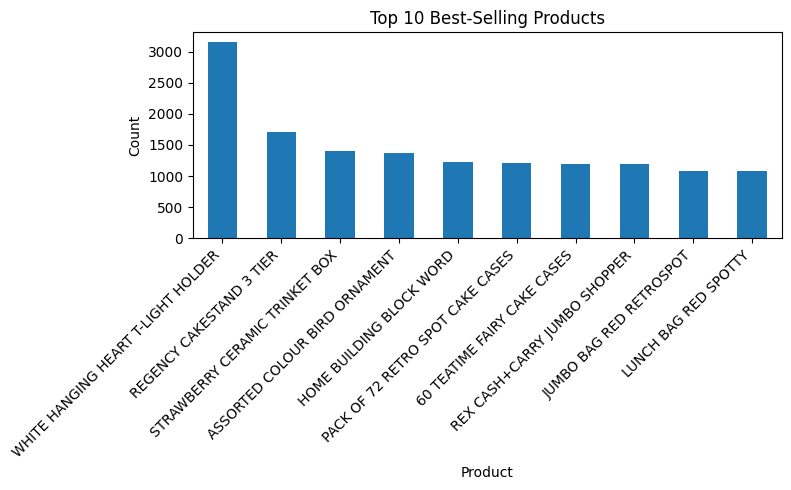

In [7]:
top_10_products = df["Description"].value_counts().head(10)

plt.figure(figsize=(8,5))
top_10_products.plot(kind="bar")
plt.title("Top 10 Best-Selling Products")
plt.ylabel("Count")
plt.xlabel("Product")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


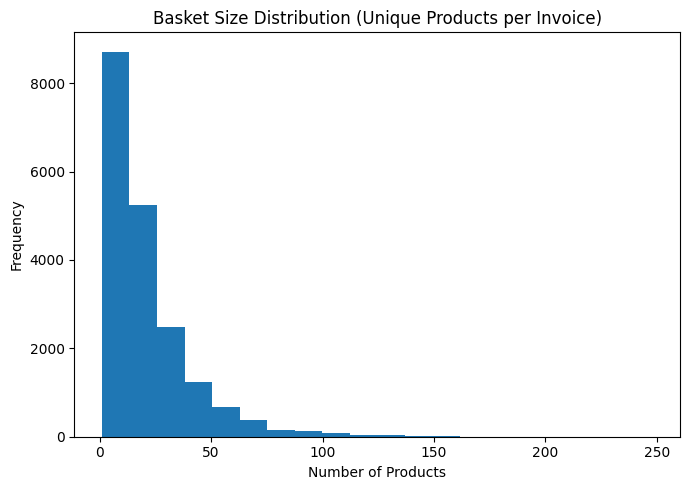

In [8]:
basket_size = df.groupby("Invoice")["Description"].nunique()

plt.figure(figsize=(7,5))
plt.hist(basket_size, bins=20)
plt.title("Basket Size Distribution (Unique Products per Invoice)")
plt.xlabel("Number of Products")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


## 4. Basket Construction (Top 300 Products)

To improve computational efficiency for association rule mining, we restrict the analysis to the **top 300 most frequently purchased products**.


In [9]:
top_products = df["Description"].value_counts().head(300).index
df_small = df[df["Description"].isin(top_products)].copy()

df_small.shape


(157912, 8)

In [10]:
basket = (
    df_small.groupby(["Invoice", "Description"])["Quantity"]
    .sum()
    .unstack(fill_value=0)
)

# Convert to boolean for Apriori
basket = (basket > 0)

basket.shape


(17238, 300)

## 5. Association Rules (Apriori)

We extract frequent itemsets and generate association rules.  
(For speed and stability, a slightly higher support threshold is used.)


In [11]:
frequent_items = apriori(
    basket,
    min_support=0.02,   # was 0.01; increased for speed
    use_colnames=True
)

rules = association_rules(
    frequent_items,
    metric="confidence",
    min_threshold=0.3
)

rules = rules.sort_values("confidence", ascending=False)
rules.head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
41,(SWEETHEART CERAMIC TRINKET BOX),(STRAWBERRY CERAMIC TRINKET BOX),0.046873,0.077445,0.036083,0.769802,9.939960,1.0,0.032453,4.007658,0.943627,0.408941,0.750478,0.617860
39,(RED HANGING HEART T-LIGHT HOLDER),(WHITE HANGING HEART T-LIGHT HOLDER),0.057663,0.175252,0.041884,0.726358,4.144641,1.0,0.031779,3.013968,0.805152,0.219253,0.668211,0.482676
46,(WOODEN PICTURE FRAME WHITE FINISH),(WOODEN FRAME ANTIQUE WHITE),0.047453,0.058533,0.032138,0.677262,11.570501,1.0,0.029361,2.917120,0.959085,0.435192,0.657196,0.613160
38,(PINK BLUE FELT CRAFT TRINKET BOX),(PINK CREAM FELT CRAFT TRINKET BOX),0.033066,0.041420,0.020130,0.608772,14.697494,1.0,0.018760,2.450182,0.963832,0.370331,0.591867,0.547383
45,(WOOD 2 DRAWER CABINET WHITE FINISH),(WOOD S/3 CABINET ANT WHITE FINISH),0.033705,0.038520,0.020478,0.607573,15.773111,1.0,0.019180,2.450088,0.969270,0.395740,0.591851,0.569600
3,(PACK OF 60 DINOSAUR CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.035445,0.065901,0.020710,0.584288,8.866160,1.0,0.018374,2.246986,0.919814,0.256835,0.554959,0.449274
10,(HEART OF WICKER SMALL),(HEART OF WICKER LARGE),0.050702,0.057837,0.028484,0.561785,9.713188,1.0,0.025551,2.150000,0.944958,0.355797,0.534884,0.527131
13,(LOVE BUILDING BLOCK WORD),(HOME BUILDING BLOCK WORD),0.055053,0.068105,0.030282,0.550053,8.076498,1.0,0.026533,2.071119,0.927231,0.326046,0.517169,0.497343
47,(WOODEN FRAME ANTIQUE WHITE),(WOODEN PICTURE FRAME WHITE FINISH),0.058533,0.047453,0.032138,0.549058,11.570501,1.0,0.029361,2.112351,0.970373,0.435192,0.526594,0.613160
27,(LUNCH BAG PINK RETROSPOT),(LUNCH BAG RED SPOTTY),0.042348,0.061376,0.022856,0.539726,8.793759,1.0,0.020257,2.039272,0.925475,0.282640,0.509629,0.456063


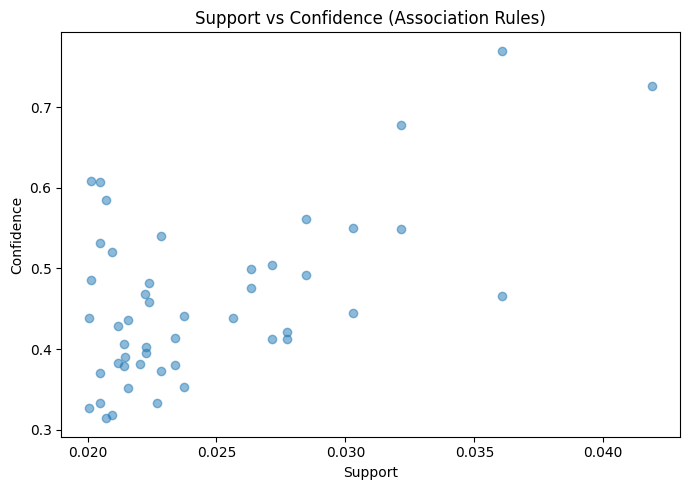

In [12]:
plt.figure(figsize=(7,5))
plt.scatter(rules["support"], rules["confidence"], alpha=0.5)
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.title("Support vs Confidence (Association Rules)")
plt.tight_layout()
plt.show()


In [13]:
# Optional: save rules for further use
rules.to_csv("rules.csv", index=False)


## 6. Interpreting Results

We generate an invoice-level product list (basket view) using the filtered dataset (`df_small`) to make results easier to interpret.


In [14]:
basket_list = (
    df_small.groupby("Invoice")["Description"]
    .apply(lambda x: list(set(x)))
    .reset_index(name="Products")
)

basket_list.head()


,Invoice,Products
0,489434,"[STRAWBERRY CERAMIC TRINKET BOX, SAVE THE PLAN..."
1,489436,"[AREA PATROLLED METAL SIGN, LOVE BUILDING BLOC..."
2,489437,"[HANGING HEART ZINC T-LIGHT HOLDER, WOODEN BOX..."
3,489438,"[GINGHAM HEART DOORSTOP RED, JUMBO BAG TOYS]"
4,489439,"[RED/WHITE DOTS RUFFLED UMBRELLA, BAKING SET 9..."


In [15]:
basket_preview = (
    df_small.groupby("Invoice")["Description"]
    .apply(lambda x: ", ".join(sorted(set(x))))
    .head(5)
)

basket_preview


Invoice
489434    PINK DOUGHNUT TRINKET POT, SAVE THE PLANET MUG...
489436    AREA PATROLLED METAL SIGN, ASSORTED COLOUR BIR...
489437    CHOCOLATE HOT WATER BOTTLE, FELTCRAFT DOLL EMI...
489438          GINGHAM HEART  DOORSTOP RED, JUMBO BAG TOYS
489439    ASSORTED COLOUR MINI CASES, BAKING SET 9 PIECE...
Name: Description, dtype: object

In [16]:
rules[["antecedents", "consequents", "support", "confidence", "lift"]].head(10)


,antecedents,consequents,support,confidence,lift
41,(SWEETHEART CERAMIC TRINKET BOX),(STRAWBERRY CERAMIC TRINKET BOX),0.036083,0.769802,9.939960
39,(RED HANGING HEART T-LIGHT HOLDER),(WHITE HANGING HEART T-LIGHT HOLDER),0.041884,0.726358,4.144641
46,(WOODEN PICTURE FRAME WHITE FINISH),(WOODEN FRAME ANTIQUE WHITE),0.032138,0.677262,11.570501
38,(PINK BLUE FELT CRAFT TRINKET BOX),(PINK CREAM FELT CRAFT TRINKET BOX),0.020130,0.608772,14.697494
45,(WOOD 2 DRAWER CABINET WHITE FINISH),(WOOD S/3 CABINET ANT WHITE FINISH),0.020478,0.607573,15.773111
3,(PACK OF 60 DINOSAUR CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.020710,0.584288,8.866160
10,(HEART OF WICKER SMALL),(HEART OF WICKER LARGE),0.028484,0.561785,9.713188
13,(LOVE BUILDING BLOCK WORD),(HOME BUILDING BLOCK WORD),0.030282,0.550053,8.076498
47,(WOODEN FRAME ANTIQUE WHITE),(WOODEN PICTURE FRAME WHITE FINISH),0.032138,0.549058,11.570501
27,(LUNCH BAG PINK RETROSPOT),(LUNCH BAG RED SPOTTY),0.022856,0.539726,8.793759


## (Optional) Top Co-occurring Product Pairs

This section provides an additional view of the most frequent product pairs across invoices.


In [17]:
pairs = []

for invoice, group in df_small.groupby("Invoice"):
    items = list(set(group["Description"]))
    pairs.extend(combinations(items, 2))

pair_counts = Counter(pairs)
pair_counts.most_common(10)


[(('RED HANGING HEART T-LIGHT HOLDER', 'WHITE HANGING HEART T-LIGHT HOLDER'),
  652),
 (('HEART OF WICKER SMALL', 'HEART OF WICKER LARGE'), 489),
 (('PACK OF 72 RETRO SPOT CAKE CASES', '60 TEATIME FAIRY CAKE CASES'), 474),
 (('PACK OF 60 PINK PAISLEY CAKE CASES', '60 TEATIME FAIRY CAKE CASES'), 442),
 (('WOODEN FRAME ANTIQUE WHITE', 'WHITE HANGING HEART T-LIGHT HOLDER'), 438),
 (('STRAWBERRY CERAMIC TRINKET BOX', 'SWEETHEART CERAMIC TRINKET BOX'), 417),
 (('LUNCH BAG PINK RETROSPOT', 'LUNCH BAG RED SPOTTY'), 389),
 (('WOODEN PICTURE FRAME WHITE FINISH', 'WHITE HANGING HEART T-LIGHT HOLDER'),
  379),
 (('HOME BUILDING BLOCK WORD', 'WHITE HANGING HEART T-LIGHT HOLDER'), 375),
 (('LUNCH BAG  BLACK SKULL.', 'LUNCH BAG RED SPOTTY'), 373)]